In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import wfdb
from random import shuffle

import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch.nn.functional as F


from IPython.display import Image

# Introduction 

## What is  Semantic Segmentation
- 이미지에서 객체 단위로 의미있는 물체 혹은 구간을 분할하는 작업을 의미 [출처](https://bskyvision.com/491)
<img src="../figs/seg_example.png">   


- 즉, 이미지의 픽셀 단위로 객체의 레이블을 예측하는 작업이라고 생각할 수 있음 
<img src="../figs/seg_example2.png"> 

- ECG 심전도에도 이런 sementic한 구간이 존재한다. 그러므로 ECG segmentation도 가능하다. [출처](https://sev.iseverance.com/heart/health_info/education/normal/view.asp?con_no=7111)
<img src="../figs/ECG.jpg">

# Methods

## Model : U-Net
- Deep learning Segmentation의 대표적인 모델로 아래 그림과 같이 U자 모양의 아키텍쳐를 가지고 있다고 하여 붙여진 이름
- Layer connected autoencoder로도 생각할 수 있다. 
- 마지막 CNN layer에 원본 직후의 feature map을 전달해줌으로써 원본 형태에 대한 복원 성능을 높임
- 제일 마지막 Layer에는 Fully Convolutional Network을 해줌
<img src="../figs/unet_arch.png">


- 본 연구의 모델 구조는 "Deep learning for ECG segmentation"[link]
(https://arxiv.org/pdf/2001.04689.pdf)이라는 논문을 참조하였음
<img src="../figs/model.png">

## Dataset - LUDB
- Lobachevsky University Electrocardiography Database (LUDB) [link](https://physionet.org/content/ludb/1.0.0/)
- LUDB is an ECG signal database with marked boundaries and peaks of P, T waves and QRS complexes.
- The database consists of **200 10-second 12-lead ECG signal records** representing different morphologies of the ECG signal. 
- The ECGs were collected from healthy volunteers and patients of the Nizhny Novgorod City Hospital No 5 in 2017–2018. 
- The patients had various cardiovascular diseases while some of them had pacemakers. 
- The boundaries of P, T waves and QRS complexes were **manually annotated** by cardiologists for all 200 records. 

In [12]:
folder_path = '/mnt/biosignal_DB/LUDB/physionet.org/files/ludb/1.0.0'
file_list = os.listdir(folder_path)
record_list = pd.read_csv(os.path.join(folder_path,'RECORDS')).values.ravel()

- MIMIC data 구조
- dat: 실제 데이터 저장
- hea: 데이터 저장 환경 등과 같은 정보 저장
- atr,att... : dat에 대한 다양한 annotation file

In [15]:
sorted(file_list)

['1.atr_avf',
 '1.atr_avl',
 '1.atr_avr',
 '1.atr_i',
 '1.atr_ii',
 '1.atr_iii',
 '1.atr_v1',
 '1.atr_v2',
 '1.atr_v3',
 '1.atr_v4',
 '1.atr_v5',
 '1.atr_v6',
 '1.dat',
 '1.hea',
 '10.atr_avf',
 '10.atr_avl',
 '10.atr_avr',
 '10.atr_i',
 '10.atr_ii',
 '10.atr_iii',
 '10.atr_v1',
 '10.atr_v2',
 '10.atr_v3',
 '10.atr_v4',
 '10.atr_v5',
 '10.atr_v6',
 '10.dat',
 '10.hea',
 '100.atr_avf',
 '100.atr_avl',
 '100.atr_avr',
 '100.atr_i',
 '100.atr_ii',
 '100.atr_iii',
 '100.atr_v1',
 '100.atr_v2',
 '100.atr_v3',
 '100.atr_v4',
 '100.atr_v5',
 '100.atr_v6',
 '100.dat',
 '100.hea',
 '101.atr_avf',
 '101.atr_avl',
 '101.atr_avr',
 '101.atr_i',
 '101.atr_ii',
 '101.atr_iii',
 '101.atr_v1',
 '101.atr_v2',
 '101.atr_v3',
 '101.atr_v4',
 '101.atr_v5',
 '101.atr_v6',
 '101.dat',
 '101.hea',
 '102.atr_avf',
 '102.atr_avl',
 '102.atr_avr',
 '102.atr_i',
 '102.atr_ii',
 '102.atr_iii',
 '102.atr_v1',
 '102.atr_v2',
 '102.atr_v3',
 '102.atr_v4',
 '102.atr_v5',
 '102.atr_v6',
 '102.dat',
 '102.hea',
 '103.a

In [16]:
pid = record_list[0]
# rdrecord : dat,hea를 동시에 읽어서 반환
record = wfdb.rdrecord(os.path.join(folder_path,str(pid)))
# annotation read
atr_ii = wfdb.rdann(os.path.join(folder_path,str(pid)),extension='atr_ii')

In [59]:
ECG_sample = record.p_signal[:,1] 
record.__dict__

{'record_name': '2',
 'n_sig': 12,
 'fs': 500,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 5000,
 'base_time': None,
 'base_date': None,
 'comments': ['<age>: 64',
  '<sex>: M',
  '<diagnoses>:',
  'Electric axis of the heart: normal.',
  'Left atrial hypertrophy.',
  'Left ventricular hypertrophy.',
  'Non-specific repolarization abnormalities: posterior wall.'],
 'sig_name': ['i',
  'ii',
  'iii',
  'avr',
  'avl',
  'avf',
  'v1',
  'v2',
  'v3',
  'v4',
  'v5',
  'v6'],
 'p_signal': array([[-161.99997231,   55.0045674 ,  216.99565556, ...,  -11.99084437,
          141.99567535,   -2.00726422],
        [-140.00083059,   52.00313193,  191.99918872, ...,    7.00399788,
          160.00726988,    7.00812077],
        [-192.0050943 ,   35.00587237,  226.99639995, ...,    0.        ,
          154.99757671,    5.00085655],
        ...,
        [ -17.00405606,  200.00326243,  216.99565556, ...,  151.98675404,
          135.00540581,  110.00154006],
        [ -36.99593472,  3

ECG lead II


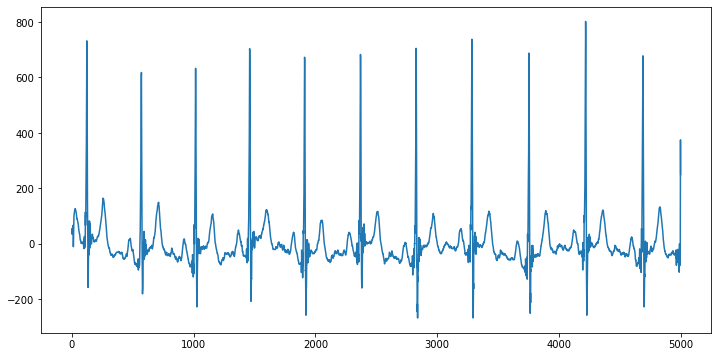

In [23]:
print("ECG lead II")
plt.figure(figsize=(12,6))
plt.plot(record.p_signal[:,1])

In [25]:
atr_ii.__dict__

{'record_name': '2',
 'extension': 'atr_ii',
 'sample': array([ 547,  569,  592,  659,  709,  750,  896,  920,  954,  995, 1015,
        1036, 1107, 1154, 1204, 1333, 1366, 1401, 1435, 1459, 1485, 1547,
        1599, 1640, 1793, 1820, 1852, 1886, 1910, 1929, 2007, 2052, 2091,
        2248, 2276, 2313, 2346, 2369, 2389, 2462, 2509, 2555, 2710, 2737,
        2769, 2799, 2826, 2847, 2931, 2968, 3008, 3168, 3192, 3226, 3261,
        3284, 3309, 3377, 3426, 3469, 3632, 3657, 3692, 3727, 3753, 3772,
        3843, 3890, 3932, 4096, 4121, 4161, 4195, 4218, 4236]),
 'symbol': ['(',
  'N',
  ')',
  '(',
  't',
  ')',
  '(',
  'p',
  ')',
  '(',
  'N',
  ')',
  '(',
  't',
  ')',
  '(',
  'p',
  ')',
  '(',
  'N',
  ')',
  '(',
  't',
  ')',
  '(',
  'p',
  ')',
  '(',
  'N',
  ')',
  '(',
  't',
  ')',
  '(',
  'p',
  ')',
  '(',
  'N',
  ')',
  '(',
  't',
  ')',
  '(',
  'p',
  ')',
  '(',
  'N',
  ')',
  '(',
  't',
  ')',
  '(',
  'p',
  ')',
  '(',
  'N',
  ')',
  '(',
  't',
  ')',
  '(',


In [85]:
target_Seg = 't' # p N t
position = np.where(np.array(atr_ii.symbol)==target_Seg)[0]
position_onset = position-1
position_offset = position+1

idx_onset= [atr_ii.sample[idx] for idx in position_onset]
idx_offset= [atr_ii.sample[idx] for idx in position_offset]
idx_all_set = [ [onset,offset] for (onset,offset) in zip(idx_onset,idx_offset)]

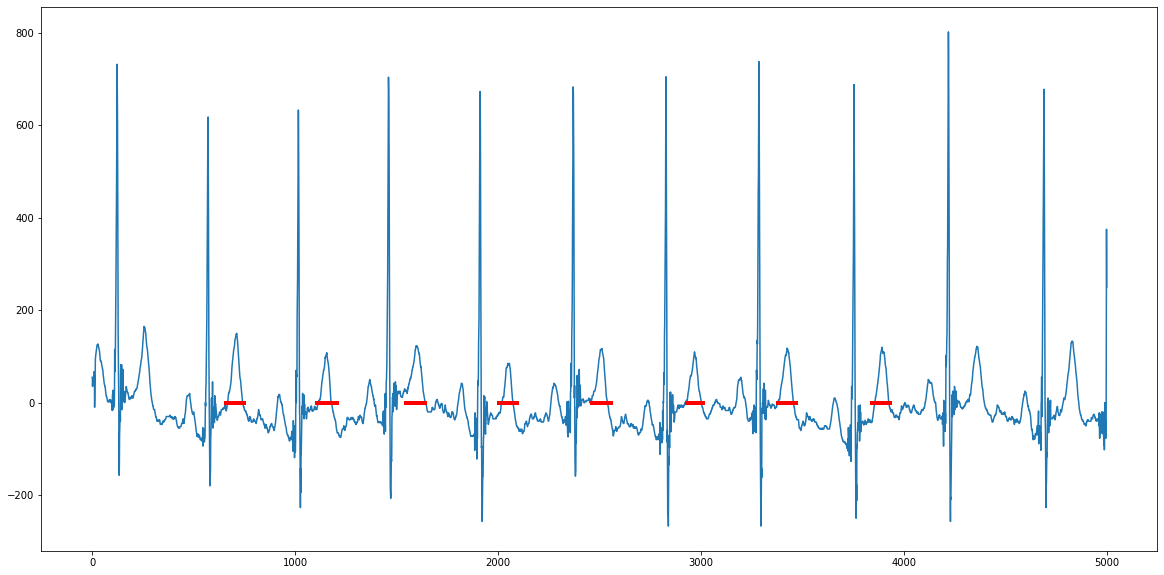

In [86]:
plt.figure(figsize=(20,10))
plt.plot(ECG_sample)
for points in idx_all_set:
    plt.plot(points,[0,0],c='R',linewidth=4)
plt.show()

### Data preprocessing
- Sinus 단위로 자름, P_onset을 시작점으로 600개의 데이터로 작름 약 1.2 (600/500)초

In [ ]:
# wave_len = 600
# for number,pid in enumerate(record_list):
#     print('{}/{}'.format(number,len(record_list)))
#     record = wfdb.rdrecord(os.path.join(folder_path,str(pid)))
#     atr_ii = wfdb.rdann(os.path.join(folder_path,str(pid)),extension='atr_ii')

#     atr_symbols = np.array(atr_ii.symbol)
#     atr_points = atr_ii.sample
#     lead_II_idx = np.where(np.array(record.sig_name)=='ii')[0][0]
#     lead_II = record.p_signal[:,lead_II_idx]

#     p_onset_list = np.where(np.array(atr_symbols)=='p')[0]-1
    
#     #p를 시작점으로 모든 segment를 자르자.
#     for idx,p_onset in enumerate(p_onset_list):
#         p_idx = atr_points[p_onset]
#         lead_seg = lead_II[p_idx:p_idx+wave_len] ##df에 들어가

#         include_symbols_idx = atr_points[(atr_points>=p_idx)&(atr_points<p_idx+600)]

#         # segments 안에 존재하는 symbol list
#         seg_symbols = atr_symbols[np.isin(atr_points,include_symbols_idx)]
#         # 해당 symbol의 seg ECG 상 실제 위치
#         seg_sybols_idx = include_symbols_idx - p_idx

#         unet_label_list = list()
#         unet_label_list.append(lead_seg)
#         for symbol in ['p','N','t']:
#             # seg_symbol list에서 각 심볼 위치
#             PQRS_seg_symbols = np.where(seg_symbols==symbol)[0]

#             # seg_symbol list에서 p onset 위치
#             Onset_seg_symbols = PQRS_seg_symbols-1
#             Offset_seg_symbols = PQRS_seg_symbols+1

#             dummy = np.zeros(wave_len) #df에 들어가
#             for onset,offset in zip(Onset_seg_symbols,Offset_seg_symbols[:len(Onset_seg_symbols)]):
#                 try:
#                     onset_idx = seg_sybols_idx[onset]
#                     offset_idx = seg_sybols_idx[offset]
#                     dummy[onset_idx:offset_idx] =1
#                 except IndexError:
#                     pass
#             unet_label_list.append(dummy)
        
#         if unet_label_list[-1].sum()!=0: # T가 존재해야지만 저장한다.
#             seg_remain = np.logical_or(unet_label_list[1] ,unet_label_list[2])
#             seg_remain = (np.logical_or(seg_remain,unet_label_list[3])-1)*(-1)
#             unet_label_list.append(seg_remain)
            
#             #np.save('../data/segments/{}_{}'.format(pid,idx),np.array(unet_label_list))

## Segmenst data load
- Label이 P,QTS,T 뿐만 아니라 나머지 잔여부분을 나타내는 것까지 포함하여 4개로 존재

In [87]:
N=10

1235
14


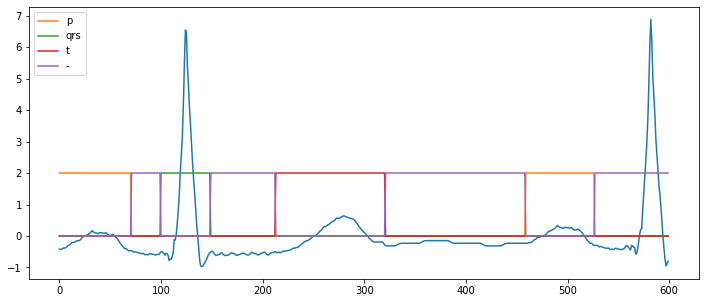

In [92]:
seg_flielist = os.listdir('../data/segments/')
print(len(seg_flielist))

seg_file_df = pd.DataFrame([[filename.split('_')[0],filename]for filename in seg_flielist],columns=['pid','filename'])
seg_file_df = seg_file_df.sort_values(['pid','filename'])
seg_file_df['filepath'] = seg_file_df.filename.apply(lambda x : os.path.join('../data/segments',x))
seg_file_df = seg_file_df[seg_file_df.pid!='.ipynb']

seg = np.load(os.path.join('../data/segments',seg_file_df.filename.tolist()[N]))

plt.figure(figsize=(12,5))
plt.plot((seg[0]-np.mean(seg[0]))/np.std(seg[0]))
plt.plot((seg[1]*2),label='p')
plt.plot((seg[2]*2),label='qrs')
plt.plot((seg[3]*2),label='t')
plt.plot(seg[4]*2,label='-')
plt.legend()
print(N)
N+=1

In [94]:
# label이 어떤 형식으로 되어 있는지
# P에 대한 label 
seg[1]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

# Model Train

## dataset

In [95]:
class segment_dataset(Dataset):
    def __init__(self,file_df):
        self.filepath = file_df.filepath.tolist()
        
    def __len__(self):
        return len(self.filepath)
    
    def __getitem__(self,item):
        try:
            seg = np.load(self.filepath[item])
            ecg_II = (seg[0]-np.mean(seg[0]))/np.std(seg[0])
            mask_arr = seg[1:,:]
        except:
            print(self.filepath[item])
        
        return torch.from_numpy(ecg_II).unsqueeze(0),torch.from_numpy(mask_arr)


## Model Structure : U-net

In [97]:
class CBR_1D(nn.Module):
    def __init__(self,in_channels,out_channels,kernel=9,stride=1,padding=4):
        super().__init__()
        self.seq_list = [
        nn.Conv1d(in_channels,out_channels,kernel,stride,padding,bias=False),
        nn.BatchNorm1d(out_channels),
        nn.ReLU()]
        
        self.seq = nn.Sequential(*self.seq_list)
        
    def forward(self,x):
        return self.seq(x)


In [99]:
class Unet_1D(nn.Module):
    def __init__(self,class_n,layer_n):
        super().__init__()
        
        ### ------- encoder -----------
        self.enc1_1 = CBR_1D(1,layer_n)
        self.enc1_2 = CBR_1D(layer_n,layer_n)
        self.enc1_3 = CBR_1D(layer_n,layer_n)
        
        self.enc2_1 = CBR_1D(layer_n,layer_n*2)
        self.enc2_2 = CBR_1D(layer_n*2,layer_n*2)
        
        self.enc3_1 = CBR_1D(layer_n*2,layer_n*4)
        self.enc3_2 = CBR_1D(layer_n*4,layer_n*4)
        
        self.enc4_1 = CBR_1D(layer_n*4,layer_n*8)
        self.enc4_2 = CBR_1D(layer_n*8,layer_n*8)
        
#         self.enc5_1 = CBR_1D(32,64)
#         self.enc5_2 = CBR_1D(64,64)
        
#         self.upsample_1 = nn.ConvTranspose1d(kernel_size=8,stride=2,padding=3)
#         self.dec4_1 = CBR_1D(32+64,32)
#         self.dec4_2 = CBR_1D(32,32)
        
        ### ------- decoder -----------
        self.upsample_3 = nn.ConvTranspose1d(layer_n*8,layer_n*8,kernel_size=8,stride=2,padding=3)
        self.dec3_1 = CBR_1D(layer_n*4+layer_n*8,layer_n*4)
        self.dec3_2 = CBR_1D(layer_n*4,layer_n*4)
        
        self.upsample_2 = nn.ConvTranspose1d(layer_n*4,layer_n*4,kernel_size=8,stride=2,padding=3)
        self.dec2_1 = CBR_1D(layer_n*2+layer_n*4,layer_n*2)
        self.dec2_2 = CBR_1D(layer_n*2,layer_n*2)
        
        self.upsample_1 = nn.ConvTranspose1d(layer_n*2,layer_n*2,kernel_size=8,stride=2,padding=3)
        self.dec1_1 = CBR_1D(layer_n*1+layer_n*2,layer_n*1)
        self.dec1_2 = CBR_1D(layer_n*1,layer_n*1)
        self.dec1_3 = CBR_1D(layer_n*1,class_n)
        self.dec1_4 = CBR_1D(class_n,class_n)
        
    def forward(self,x):
        
        enc1 = self.enc1_1(x)
        enc1 = self.enc1_2(enc1)
        enc1 = self.enc1_3(enc1)
        
        enc2 = nn.functional.max_pool1d(enc1,2)
        enc2 = self.enc2_1(enc2)
        enc2 = self.enc2_2(enc2)
        
        enc3 = nn.functional.max_pool1d(enc2,2)
        enc3 = self.enc3_1(enc3)
        enc3 = self.enc3_2(enc3)
        
        enc4 = nn.functional.max_pool1d(enc3,2)        
        enc4 = self.enc4_1(enc4)
        enc4 = self.enc4_2(enc4)
        
        dec3 = self.upsample_3(enc4)
        dec3 = self.dec3_1(torch.cat([enc3,dec3],dim=1)) ##concat
        dec3 = self.dec3_2(dec3)
        
        dec2 = self.upsample_2(dec3)
        dec2 = self.dec2_1(torch.cat([enc2,dec2],dim=1)) ##concat
        dec2 = self.dec2_2(dec2)
        
        dec1 = self.upsample_1(dec2)
        dec1 = self.dec1_1(torch.cat([enc1,dec1],dim=1)) ##concat
        dec1 = self.dec1_2(dec1)
        dec1 = self.dec1_3(dec1)
        out = self.dec1_4(dec1)
        
        return out

## Model Train

In [107]:
## hyper parameter
device = 'cpu'
class_n = 4
total_epoch = 300

lr = 0.001
batch_size = 256

- 환자 단위로 Train과 valid를 나누어 줌
- 심전도는 환자 개별마다 특성이 뚜렷함으로 만약 환자가 섞이면 너무 쉬운 문제가 되어버림

In [109]:
pid_list = list(set(seg_file_df.pid.tolist()))
shuffle(pid_list)

tr_pid_list = pid_list[:int(len(pid_list)*(3/4))]
vd_pid_list = pid_list[int(len(pid_list)*(3/4)):]

tr_file_df = seg_file_df.query("pid in @tr_pid_list")
vd_file_df = seg_file_df.query("pid in @vd_pid_list")

tr_dataset = segment_dataset(tr_file_df)
vd_dataset = segment_dataset(vd_file_df)

tr_loader = DataLoader(tr_dataset,batch_size=batch_size,shuffle=True,drop_last=True)
vd_loader = DataLoader(vd_dataset,batch_size=batch_size)

- Model, optimizer, loss, schedular 생성

In [102]:
from torch.optim.lr_scheduler import CosineAnnealingLR,StepLR,ReduceLROnPlateau

model = Unet_1D(4,6).double().to(device)
optim = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optim,'min',patience=10,factor=0.8,min_lr=1e-8)
loss_f = torch.nn.BCEWithLogitsLoss()

In [ ]:
#tr_output_list = list()
for epoch in range(total_epoch):
    model.train()
    train_loss = 0
    tr_output_list = list()
    for idx,(X,y) in enumerate(tr_loader):
        optim.zero_grad()
        
        y_pred = model(X.to(device))
        loss = loss_f(y_pred,y.to(device))
        
        loss.backward()
        optim.step()
        
        train_loss+=loss.cpu().item()/len(tr_loader)
        out_pred = F.softmax(y_pred,1).detach().cpu().numpy().argmax(axis=1)
        tr_output_list.extend(list(out_pred))
        
    print("------------- {} epoch-------------".format(epoch))
    print("Train loss : {:.3f}".format(train_loss))
    
    vd_loss = 0
    model.eval()
    for idx,(X,y) in enumerate(vd_loader):

        y_pred = model(X.to(device))
        out_pred = F.softmax(y_pred,1).detach().cpu().numpy().argmax(axis=1)
        
        loss = loss_f(y_pred,y.to(device))
        vd_loss+=loss.cpu().item()/len(vd_loader)
    print("Valid loss : {:.3f}".format(vd_loss))



# Results

In [111]:
model = torch.load('../data/model.pt',map_location=device)

In [112]:
vd_ecg_list = list()
vd_label_list = list()
vd_output_list = list()

model.eval()

for idx,(X,y) in enumerate(vd_loader):

    y_pred = model(X.to(device))
    out_pred = F.softmax(y_pred,1).detach().cpu().numpy().argmax(axis=1)
    
    vd_output_list.extend(list(out_pred))
    vd_ecg_list.extend(list(X.cpu().detach().numpy().squeeze(1)))
    vd_label_list.extend(list(y.cpu().detach().numpy()))
    break

In [114]:
from scipy.stats import mode
def output_sliding_voting(output,window=5):
    # window size must be odd number
    output = pd.Series(output).rolling(window).apply(lambda x : mode(x)[0][0]).fillna(method='bfill')
    return output.values

In [141]:
sample_n = 0

120


/home/jjong/anaconda3/envs/torch_v1.3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  after removing the cwd from sys.path.


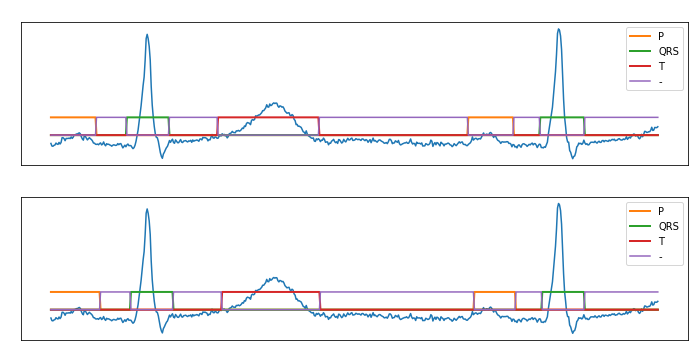

In [154]:
print(sample_n)
ecg = vd_ecg_list[sample_n]
label = vd_label_list[sample_n]

output = vd_output_list[sample_n]
output = output_sliding_voting(output,9)

p = (output == 0)
N = (output == 1)
t = (output == 2)
r = (output == 3)


with plt.rc_context({'xtick.color':'white','ytick.color':'white'}):
    
    fig,axes = plt.subplots(2,1,figsize=(10,5))
    fig.tight_layout()
    
    axes[0].set_title("True boundary",color='white')
    axes[0].plot(ecg)
    axes[0].plot(label[0],label='P',linewidth=2)
    axes[0].legend(loc="upper right")
    axes[0].plot(label[1],label='QRS',linewidth=2)
    axes[0].plot(label[2],label='T',linewidth=2)
    axes[0].plot(label[3],label='-')
    axes[0].legend(loc="upper right")

    axes[1].set_title('Deep learnig Segmentation',color='white')
    axes[1].plot(ecg)
    axes[1].plot(p,label='P',linewidth=2)
    axes[1].plot(N,label='QRS',linewidth=2)
    axes[1].plot(t,label='T',linewidth=2)
    axes[1].plot(r,label='-')
    axes[1].legend(loc="upper right")
sample_n+=10

## External Validation

<img src="../figs/MUSE1.png">
<img src="../figs/MUSE2.png">
<img src="../figs/MUSE3.png">
<img src="../figs/MUSE4.png">
<img src="../figs/MUSE5.png">

# Discussion 
- 200명 환자의 10초 데이터, 환자 당 약 7개의 segmentation 
- 1400개의 데이터로 진행하였음에도 꽤 좋은 성능이 나오는 것을 확인하였음
- 객관적으로 이를 평가하지 못하였음
- 학습데이터가 무조건 P onset을 시작점으로 하여 MUSE에서 성능이 이상하게 나오는 것을 추측
- Augementation으로써 다양한 시작점을 넣고 훈련한다면 시작 시점에 robust한 모델이 나올 것으로 예상할 수 있음